# 模型选择+过拟合和欠拟合

训练误差和泛化误差
- 训练误差：模型在训练数据上的误差
- 泛化误差：模型在新数据上的误差

例子：根据模考成绩来预测未来考试的成绩，A学生通过背书在考试中拿到好成绩，B学生知道答案背后的原因。

验证数据集和测试数据集
- 验证数据集：一个用来评估模型好坏的数据集
  - 例如：拿出50%的训练数据
  - 注意：不要跟训练数据混在一起(常犯错误)
- 测试数据集：只用一次进行测试的数据集：
  例如：
  - 未来的考试
  - 房子的实际成交价
  - 用在kaggle私有排行榜中的数据集

K则交叉验证
- 在没有足够多数据时使用
- 算法：
  - 将训练集分割成K块
  - For i = 1, ..., k
    - 使用第i块作为验证数据集，其余的作为训练数据集
  - 报告K个验证集误差的平均
- 常用： K = 5或10

## 过拟合和欠拟合

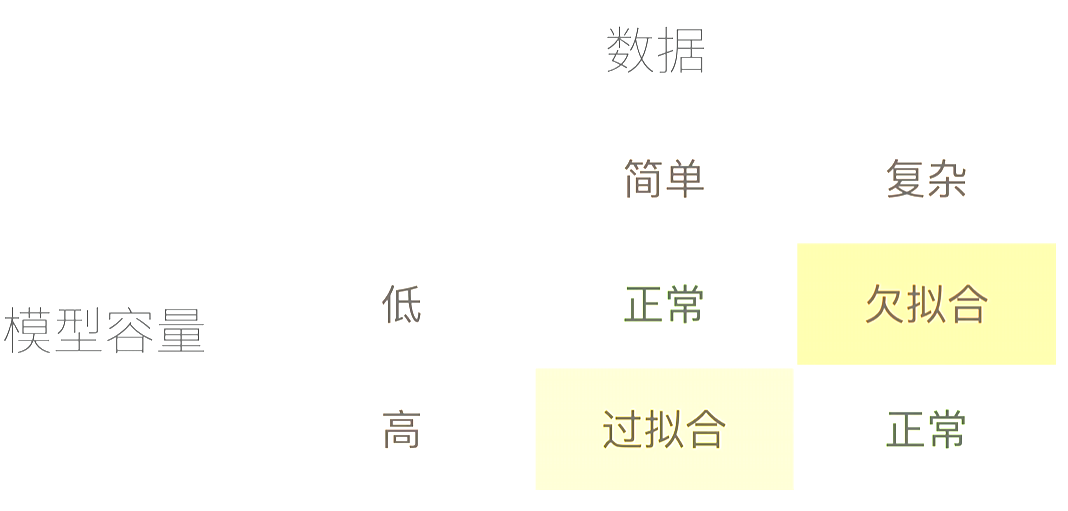

模型容量的影响

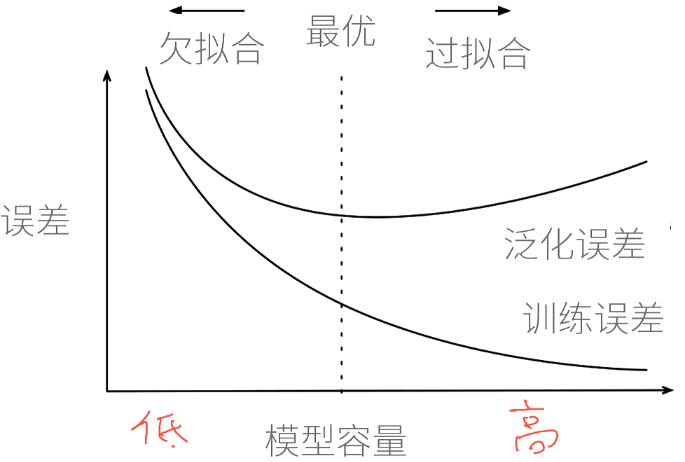

估计模型容量
- 难以在不同种类的算法之间比较
  - 例如模型和神经网络
- 给定一个模型种类，将有两个主要因素
  - 参数的个数
  - 参数值的选择范围
  
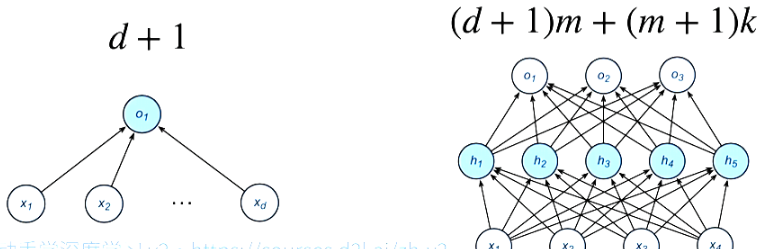

VC维
- 统计学习理论的一个核心思想
- 对于一个分类模型，VC等于一个最大的数据集的大小，不管如何标记符号，都存在一个模型对它进行完美分类

例子：线性分类器的VC维
- 2维输入的感知机，VC维=3
   - 能够分类任何三个点，但不是4个(XOR)
- 支持N维输入的感知机的VC维是N+1
- 一些多层感知机的VC维O(Nlog2N)

数据复杂度
- 多个重要因素
  - 样本个数
  - 每个样本的元素个数
  - 时间、空间结构
  - 多样性

总结
- 模型容量需要匹配数据复杂度，否则可能导致欠拟合和过拟合。
- 统计器及学习提供数学工具来衡量模型复杂度
- 实际中一般靠观察训练误差和验证误差

In [1]:
# 导入第三方库
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

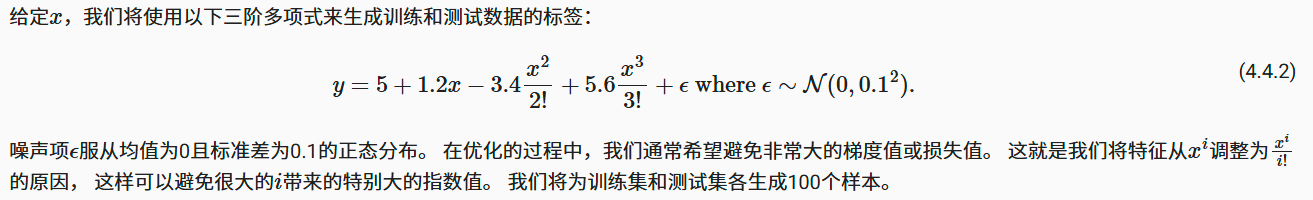

In [11]:
#多项式的最大阶数
max_degree = 20
#训练集和测试集的大小
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
#定义模型的参数，以矩阵形式
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1) #gamma(n) = (n-1)!
#labels的维度:(n_train+ n_test,)
labels = np.dot(poly_features, true_w)
#添加噪声
labels += np.random.normal(scale= 0.1, size = labels.shape)

In [12]:
#Numpy array 转换为 tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype= torch.float32) for x in [true_w, features, poly_features, labels]]
#打印模型信息
features[:2], poly_features[:2,:], labels[:2]

(tensor([[1.0107],
         [1.7175]]),
 tensor([[1.0000e+00, 1.0107e+00, 5.1076e-01, 1.7208e-01, 4.3479e-02, 8.7889e-03,
          1.4805e-03, 2.1376e-04, 2.7006e-05, 3.0328e-06, 3.0653e-07, 2.8164e-08,
          2.3722e-09, 1.8443e-10, 1.3314e-11, 8.9712e-13, 5.6670e-14, 3.3692e-15,
          1.8918e-16, 1.0064e-17],
         [1.0000e+00, 1.7175e+00, 1.4750e+00, 8.4443e-01, 3.6259e-01, 1.2455e-01,
          3.5653e-02, 8.7480e-03, 1.8781e-03, 3.5842e-04, 6.1559e-05, 9.6119e-06,
          1.3757e-06, 1.8176e-07, 2.2298e-08, 2.5532e-09, 2.7408e-10, 2.7690e-11,
          2.6422e-12, 2.3884e-13]]),
 tensor([5.5333, 6.8199]))

In [13]:
#对模型进行训练和测试
def evaluate_loss(net, data_iter, loss):
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        #将y的形状与输出保持一致
        y = y.reshape(out.shape)
        #计算损失
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [18]:
#定义训练函数
def train(train_features, test_features, train_labels, test_labels, num_epochs= 400):
    #使用均方误差作为损失函数
    loss = nn.MSELoss(reduction= 'none')
    input_shape = train_features.shape[-1]
    #已经设置了噪声，在此不使用bias
    net = nn.Sequential(nn.Linear(input_shape, 1, bias= False))
    batch_size = min(10, train_features.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)), batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)), batch_size)
    #定义优化器
    trainer = torch.optim.SGD(net.parameters(), lr= 0.01)
    #动态绘制训练曲线
    animator = d2l.Animator(xlabel= 'epoch', ylabel= loss, yscale= 'log', xlim=[1, num_epochs], ylim=[1e-3, 1e2], legend=['train_loss', 'test_loss'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        #每20轮训练绘制损失曲线
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch+ 1, (evaluate_loss(net, train_iter, loss), 
                                    evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 5.0035887  1.1896701 -3.3955796  5.600529 ]]


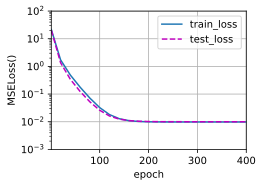

In [19]:
#三阶多项式函数拟合(正常)
#从多项式特征中选取前4个维度，即1,x,x^2/2!,x^3/3!
train(train_features= poly_features[:n_train, :4], 
      test_features= poly_features[n_train:, :4], 
      train_labels= labels[:n_train], test_labels= labels[n_train:])

weight: [[2.9984612 3.6084673]]


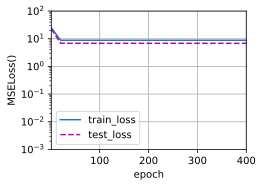

In [20]:
#线性函数拟合(欠拟合)
# 仅提供前2维特征
train(poly_features[:n_train, :2], poly_features[n_train:, :2], labels[:n_train], labels[n_train:])

weight: [[ 4.961534    1.3031362  -3.2214055   5.015799   -0.4216094   1.5663495
  -0.0399888   0.30820343  0.13166486  0.13167648 -0.08024578  0.22024244
  -0.16150363  0.01491463 -0.14268464  0.03923108  0.18682311  0.04519619
  -0.07179217  0.13919792]]


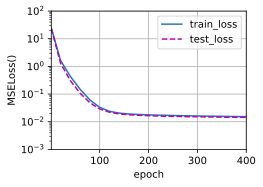

In [21]:
#高阶多项式函数拟合(过拟合)
train(poly_features[:n_train, :], poly_features[n_train:, :], labels[:n_train], labels[n_train:])